### CS 421 PROJECT

In [140]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import random
import joblib

In [141]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [142]:
# Load the dataset
data = np.load("first_batch_multi_labels.npz")
X = data["X"]
y = data["yy"]

# Create DataFrames
df_X = pd.DataFrame(X, columns=["user", "item", "rating"])
df_y = pd.DataFrame(y, columns=["user", "label"])

def engineer_features(df_X, top_features=None, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby('user').agg(
        mean_rating=('rating', 'mean'),
        median_rating=('rating', 'median'),
        std_rating=('rating', 'std'),
        count_dislike=('rating', lambda x: (x == -10).sum()),
        count_neutral=('rating', lambda x: (x == 0).sum()),
        count_like=('rating', lambda x: (x == 10).sum()),
        count_watched=('rating', lambda x: (x == 1).sum()),
        total_interactions=('rating', 'count')
    )

    # Ratio features
    df_user_features['like_ratio'] = df_user_features['count_like'] / df_user_features['total_interactions']
    df_user_features['dislike_ratio'] = df_user_features['count_dislike'] / df_user_features['total_interactions']
    df_user_features['neutral_ratio'] = df_user_features['count_neutral'] / df_user_features['total_interactions']
    df_user_features['watched_ratio'] = df_user_features['count_watched'] / df_user_features['total_interactions']

    # Weighted scores
    df_user_features['weighted_score'] = df_user_features['count_like'] * 1.5 - df_user_features['count_dislike'] * 1.5
    
    # Interaction patterns
    df_user_features['like_to_dislike_ratio'] = df_user_features['count_like'] / (df_user_features['count_dislike'] + 1)

    # Distribution features
    df_user_features['rating_skew'] = df_X.groupby('user')['rating'].apply(lambda x: skew(x))
    df_user_features['rating_kurtosis'] = df_X.groupby('user')['rating'].apply(lambda x: kurtosis(x))
    
    # User behavior patterns
    df_user_features['rating_range'] = df_X.groupby('user')['rating'].apply(lambda x: x.max() - x.min())
    df_user_features['unique_items_ratio'] = df_X.groupby('user')['item'].nunique() / df_user_features['total_interactions']
    
    # Item popularity metrics
    item_popularity = df_X.groupby('item')['rating'].agg(['mean', 'count'])
    item_popularity['popularity_score'] = item_popularity['mean'] * np.log1p(item_popularity['count'])
    
    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(df_X, item_popularity['popularity_score'], left_on='item', right_index=True)
    
    # User-item interaction features
    df_user_features['mean_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].mean()
    df_user_features['std_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].std()

    # If labels are provided, merge with df_y
    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on='user')

        # Feature selection using mutual information
        X = df_merged.drop(columns=['user', 'label'])
        y = df_merged['label']
        mi_scores = mutual_info_classif(X, y)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        
        # Select top 10 features
        top_features = mi_scores.nlargest(10).index.tolist()

        # Return the merged dataframe with selected features, label, and top features
        return df_merged[['user'] + top_features + ['label']], top_features

    # If no labels (unseen data), just select the top features
    else:
        # Ensure top_features is provided
        if top_features is None:
            raise ValueError("top_features must be provided for unseen data")
        
        # Return the dataframe with only the selected top features
        df_merged = df_user_features.reset_index()
        return df_merged[['user'] + top_features]

# Use the function
df_merged, top_features = engineer_features(df_X, df_y=df_y)

In [143]:
# Print out top features
print("Top features:", top_features)

Top features: ['watched_ratio', 'like_ratio', 'mean_rating', 'like_to_dislike_ratio', 'weighted_score', 'dislike_ratio', 'rating_kurtosis', 'neutral_ratio', 'std_rating', 'count_dislike']


In [144]:
# Features and Labels
X_features = df_merged.drop(columns=['user', 'label'])
y_labels = df_merged['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=RANDOM_SEED, stratify=y_labels)

# Handling imbalance in the training set using SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Model Training with Random Forest in One-vs-Rest scheme
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced')
ovr_model = OneVsRestClassifier(rf_model)

# Use a pipeline for scaling and modeling
pipeline = make_pipeline(StandardScaler(), ovr_model)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'onevsrestclassifier__estimator__n_estimators': [200, 225, 250, 275, 300],
    'onevsrestclassifier__estimator__max_depth': [None, 5, 10, 15],
    'onevsrestclassifier__estimator__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Use the best model from grid search
best_model = grid_search.best_estimator_

# Print out the best parameters
print("Best Parameters:", grid_search.best_params_)

# Final evaluation on the test set
y_test_pred_prob = best_model.predict_proba(X_test)
test_auc_scores = roc_auc_score(y_test, y_test_pred_prob, average=None, multi_class='ovr')
print(f"Test AUC Scores: Normal (Class 0): {test_auc_scores[0]:.4f}, Anomaly 1 (Class 1): {test_auc_scores[1]:.4f}, Anomaly 2 (Class 2): {test_auc_scores[2]:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'onevsrestclassifier__estimator__criterion': 'entropy', 'onevsrestclassifier__estimator__max_depth': 15, 'onevsrestclassifier__estimator__n_estimators': 275}
Test AUC Scores: Normal (Class 0): 0.9888, Anomaly 1 (Class 1): 0.9895, Anomaly 2 (Class 2): 0.9981


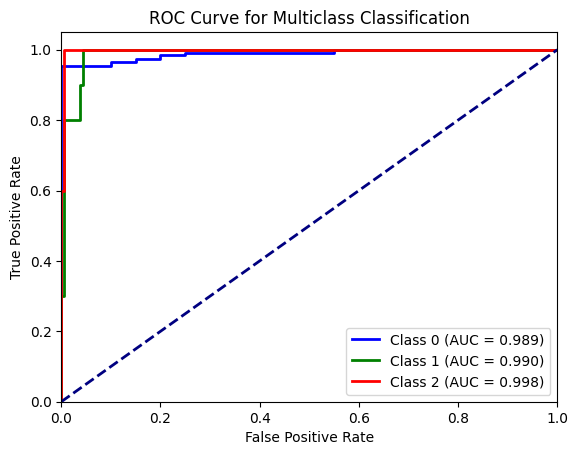

In [145]:
# Binarize the output labels for multiclass ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

[[192   7   1]
 [  2   8   0]
 [  0   1   9]]


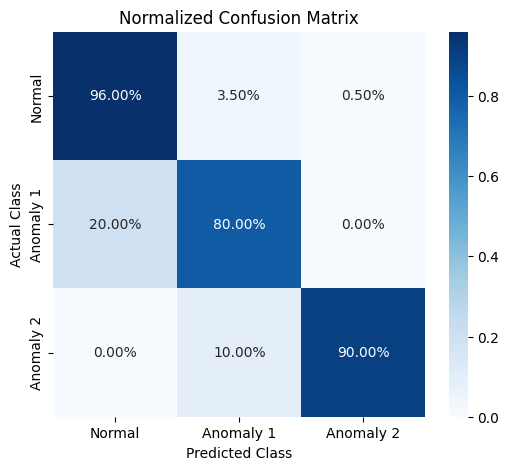

In [146]:
# Make predictions (convert probabilities to class labels)
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'], 
            yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [147]:
data_with_no_labels = np.load("second_batch_multi.npz")

df_X = pd.DataFrame(data_with_no_labels["X"], columns=["user", "item", "rating"])

df_unseen_features = engineer_features(df_X, top_features=top_features)

y_pred_prob_unseen = best_model.predict_proba(df_unseen_features.drop(columns=['user']))
y_pred_class_unseen = best_model.predict(df_unseen_features.drop(columns=['user']))

# Create a DataFrame to hold user IDs and their corresponding anomaly scores
df_anomaly_scores = pd.DataFrame({
    'user': df_unseen_features['user'],  # User IDs from unseen data
    'z0': y_pred_prob_unseen[:, 0],  # Probability for Normal class
    'z1': y_pred_prob_unseen[:, 1],  # Probability for Anomaly 1
    'z2': y_pred_prob_unseen[:, 2],   # Probability for Anomaly 2
    'predicted_class': y_pred_class_unseen   # Predicted class (0, 1, or 2)
})

df_anomaly_scores

,user,z0,z1,z2,predicted_class
0,1100,0.989170,0.010830,0.000000,0
1,1101,0.989209,0.010791,0.000000,0
2,1102,1.000000,0.000000,0.000000,0
3,1103,1.000000,0.000000,0.000000,0
4,1104,0.804000,0.124000,0.072000,0
...,...,...,...,...,...
1095,2195,0.965116,0.000000,0.034884,0
1096,2196,1.000000,0.000000,0.000000,0
1097,2197,1.000000,0.000000,0.000000,0
1098,2198,0.996283,0.003717,0.000000,0


In [148]:
df_anomaly_scores.to_csv("second_batch_anomaly_scores_hyperparameter.csv", index=False)